In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

def daily_data_wrapper(func):

    """
    function wrapper to calculate intra day volatility

    :param func: function that select specific data
    :return: function wrapper that calculate volatility
    """

    def intra_day_volatility_wrapper(dta, alldates, start_date):
        new_dta = func(dta, alldates, start_date)
        close_p = new_dta["Close"].values
        return np.sqrt(252*8*60)*np.std(close_p[1:]/close_p[:-1] - 1)
    return intra_day_volatility_wrapper


@daily_data_wrapper
def intra_day_volatility(dta, alldates, start_date):
    """
    Data selector

    :param dta: pandas data frame
    :param alldates: dates in dta
    :param start_date: specific date to select
    :return:
    """
    return dta[np.logical_and(alldates.month == start_date.month, alldates.day == start_date.day)]


def duration_data_selector(dta, duration):
    """
    Choose data for specific volatility duration

    :param dta: pandas data frame
    :param duration: 1W, 1M, 3M
    :return: date, close price, Time to maturity, volatility
    """

    if duration == "1M":
        new_dta = dta[dta["1M Maturity"] >= 0]
        return new_dta.index, new_dta["Close"].values, new_dta["1M Maturity"].values, new_dta["V1M"].values
    elif duration == "3M":
        new_dta = dta[dta["3M Maturity"] >= 0]
        return new_dta.index, new_dta["Close"].values, new_dta["3M Maturity"].values, new_dta["V3M"].values
    elif duration == "1W":
        new_dta = dta[dta["1W Maturity"] >= 0]
        return new_dta.index, new_dta["Close"].values, new_dta["1W Maturity"].values, new_dta["V1W"].values


def option_price(s, tau, sigma, k, r, q):
    """
    Calculate Black-Scholes option price

    :param s: stock price
    :param tau: time to maturity
    :param sigma: volatility
    :param k: strike price
    :param r: interest rate in foreign currency
    :param q: interest rate in base currency
    :return: option price
    """

    d1 = (np.log(s/k) + (r - q + sigma**2/2)*tau)/(sigma*tau)
    d2 = d1 - sigma*np.sqrt(tau)
    return s*np.exp(-q*tau)*norm.cdf(d1) - k * np.exp(-r*tau)*norm.cdf(d2)


def delta(s, tau, sigma, k, r, q):
    """
    Calculate Black-Scholes delta

    :param s: stock price
    :param tau: time to maturity
    :param sigma: volatility
    :param k: strike price
    :param r: interest rate in foreign currency
    :param q: interest rate in base currency
    :return: delta
    """

    d1 = (np.log(s/k) + (r - q + sigma**2/2)*tau)/(sigma*tau)
    return np.exp(-q*tau) * norm.cdf(d1)


def vega(s, tau, sigma, k, r, q):
    """
    Calculate Black-Scholes vega

    :param s: stock price
    :param tau: time to maturity
    :param sigma: volatility
    :param k: strike price
    :param r: interest rate in foreign currency
    :param q: interest rate in base currency
    :return: vega
    """

    d1 = (np.log(s/k) + (r - q + sigma**2/2)*tau)/(sigma*tau)
    return s*np.exp(-q*tau)*norm.pdf(d1)*np.sqrt(tau)


def hedging_pnl(s, tau, sigma, k, r, q):
    """
    Calculate pnl for dynamic delta hedging for every step

    :param s: stock price
    :param tau: time to maturity
    :param sigma: volatility
    :param k: strike price
    :param r: interest rate in foreign currency
    :param q: interest rate in base currency
    :return: option price path, replicating portfolio value path, total portfolio value path
    """

    option_pv = option_price(s[:-1], tau[:-1], sigma[:-1], k, r, q)
    repl_port = np.zeros((len(tau), 1))
    total_port = np.zeros((len(tau), 1))
    bank_acc = np.zeros((len(tau), 1))
    delta_vec = delta(s[:-1], tau[:-1], sigma[:-1], k, r, q)

    stock_pos = delta_vec[1:] * s[1:-1]
    stock_pos_diff = stock_pos - delta_vec[:-1] * s[1:-1]
    bank_acc[0] = option_pv[0] - delta_vec[0]*s[0]
    repl_port[0] = option_pv[0]
    dt = np.diff(tau)

    for t in range(len(dt)-1):
        bank_acc[t+1] = bank_acc[t]*(1 + dt[t]*r) - stock_pos_diff[t] *(1-dt[t]*q)
        repl_port[t+1] = stock_pos[t] + bank_acc[t+1]
        total_port[t+1] = option_pv[t+1] - repl_port[t+1] - bank_acc[0]*(1 + r*dt[0])**tau[t+1]

    option_pv = np.append(option_pv, np.maximum(s[-1] - k, 0))
    bank_acc[-1] = bank_acc[-2]*(1+dt[-1]*r)
    repl_port[-1] = delta_vec[-1]*s[-1] + bank_acc[-1]
    total_port[-1] = option_pv[-1] - repl_port[-1] - bank_acc[0]*(1+r*dt[0])**tau[-1]

    return option_pv, repl_port, total_port


def hedging_pnl_delta_band(s, tau, sigma, k, r, q, bound, func):
    """
    Calculate pnl for dynamic delta hedging according to a pre-set delta or vega bound

    :param s: stock price
    :param tau: time to maturity
    :param sigma: volatility
    :param k: strike price
    :param r: interest rate in foreign currency
    :param q: interest rate in base currency
    :param bound: delta/vega bound
    :param func: delta or vega functions as defined above
    :return: option price path, replicating portfolio value path, total portfolio value path
    """

    option_pv = option_price(s[:-1], tau[:-1], sigma[:-1], k, r, q)
    delta_vec = func(s[:-1], tau[:-1], sigma[:-1], k, r, q)

    repl_port = np.array([])
    total_port = np.array([])
    bank_acc = np.array([])

    repl_port = np.append(repl_port, option_pv[0])
    total_port = np.append(total_port, 0)
    bank_acc = np.append(bank_acc, option_pv[0] - s[0]*delta_vec[0])
    delta_diff = np.diff(delta_vec)
    cumulate_delta = 0
    time_stamp = 0
    stock_index = 0
    dt = tau[1] - tau[0]

    for i, t in enumerate(tau[1:-1]):
        cumulate_delta += delta_diff[i]
        if np.abs(cumulate_delta) >= bound:
            stock_pos = (s[i+1] - s[stock_index]) * cumulate_delta
            bank_acc = np.append(bank_acc, bank_acc[-1]*(1 + dt*r)**(t - time_stamp) - stock_pos*(1-dt*q)**(t - time_stamp))
            repl_port = np.append(repl_port, bank_acc[-1] + delta_vec[i+1] * s[i+1])
            total_port = np.append(total_port,  option_pv[i+1] - repl_port[-1] - bank_acc[0] * (1 + dt*r)**t)
            stock_index = i+1
            cumulate_delta = 0
            time_stamp = t

    stock_pos = (s[-1] - s[stock_index]) * cumulate_delta
    option_pv = np.append(option_pv, np.maximum(s[-1] - k, 0))
    bank_acc = np.append(bank_acc, bank_acc[-1]*(1 + dt*r)**(tau[-1] - time_stamp) - stock_pos*(1-dt*q)**(tau[-1] - time_stamp))
    repl_port = np.append(repl_port, bank_acc[-1] + delta_vec[-1] * s[-1])
    total_port = np.append(total_port, option_pv[-1] - repl_port[-1] - bank_acc[0] * (1 + dt*r)**tau[-1])

    return option_pv, repl_port, total_port



In [9]:
df = pd.read_excel("USDBRL_PriceHist.xlsx", index_col=0)
new_dta = df[df["1M Maturity"] >= 0]
t = np.array(new_dta["1M Maturity"], dtype=np.longfloat)
sigma = new_dta["V1M"].values
op, rep, total = hedging_pnl_delta_band(new_dta["Close"].values, t, sigma, new_dta["Close"].values[0], 0.065, 0.02, 0.000001, delta)

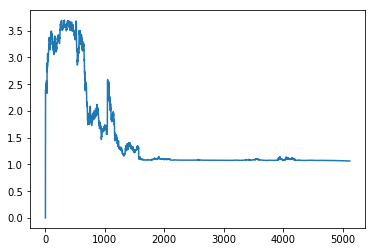

In [10]:
plt.plot(total)